In [1]:
%load_ext autoreload
%autoreload 2


import os
# set available device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import subgraph, remove_isolated_nodes, degree, index_to_mask, mask_to_index, to_dense_adj, dense_to_sparse, to_undirected, is_undirected
from tqdm import tqdm
import pandas as pd
import math
from scipy.special import softmax
from typing import Union, List, Tuple, Callable, Optional
from functools import partial, wraps


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Useful functions

### miscellaneous functions

In [2]:
def allow_batch(func: Callable) -> Callable:
    """Decorator to allow `func` to accept batched input."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        if isinstance(args[0], Batch):
            return Batch.from_data_list([func(arg, *args[1:], **kwargs) for arg in args[0].to_data_list()])
        else:
            return func(*args, **kwargs)
    return wrapper

@allow_batch
def get_oracle_rationale(graph: Data) -> Data:
    """Given original graph `graph`, return its non-reduced oracle rationale."""
    rationale = graph.clone()
    rationale.edge_index = graph.edge_index[:, graph.ground_truth_mask]
    rationale.edge_attr = graph.edge_attr[graph.ground_truth_mask]
    return rationale

@allow_batch
def reduce_graph(graph: Data, inplace: bool = False) -> Data:
    """return a new graph with isolated nodes removed."""
    if not inplace:
        graph = graph.clone()
    edge_index, edge_attr, node_mask = remove_isolated_nodes(graph.edge_index, graph.edge_attr, graph.num_nodes)
    graph.edge_index = edge_index
    graph.edge_attr = edge_attr
    graph.x = graph.x[node_mask]
    if graph.pos is not None:
        graph.pos = graph.pos[node_mask]
    return graph

def repeat_interleave_as(obj: torch.Tensor, ref: torch.Tensor, dim: int = 0) -> torch.Tensor:
    """Repeat each element of `obj` as many times as the corresponding element in `ref` along dimension `dim`."""
    if obj.size(dim) < ref.size(dim):
        assert ref.size(dim) % obj.size(dim) == 0
        obj = obj.repeat_interleave(ref.size(dim) // obj.size(dim), dim=dim)
    return obj

def reduce_interleave_as(obj: torch.Tensor, ref: torch.Tensor, dim: int = 0, reduction='mean') -> torch.Tensor:
    if obj.size(dim) > ref.size(dim):
        assert obj.size(dim) % ref.size(dim) == 0
        obj_shape = list(obj.shape)
        obj_shape[dim] = ref.size(dim)
        obj_shape.insert(dim + 1, -1)
        obj = getattr(obj.view(*obj_shape), reduction)(dim=dim + 1)
    return obj

def as_undirected(edge_index: torch.Tensor, edge_attr: Optional[torch.Tensor] = None, return_mask: bool = False):
    """remove duplicate undirected edges in `edge_index`, i.e., edge (i, j) will be removed if (j, i) is present."""
    mask = edge_index[0] <= edge_index[1]
    edge_index = edge_index[:, mask]
    if edge_attr is not None:
        edge_attr = edge_attr[mask]
    if return_mask:
        return edge_index, edge_attr, mask
    return edge_index, edge_attr

### sample functions

In [3]:
def sample_subgraphs(graph: Data, n_total: Union[int, float] = 1.0, n_pos: Union[int, float] = 0.5, n_samples: int = 10, on_edges: bool = True, force_directed: bool = False, mode: str ='random') -> List[Data]:
    """Randomly sample `n_samples` subgraphs with a total of `n_total` edges(or nodes) and `n_pos` positive edges(or nodes).

    Args:
        graph (Data): The original graph.
        n_total (Union[int, float]): The total number of edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_pos (Union[int, float]): The number of positive edges(or nodes) in the sampled subgraphs. If float, it is the ratio to the total 
            number of positive edges(or nodes) in the original graph.
        n_samples (int): The number of sampled subgraphs.
        on_edges (bool): Whether to sample on edges or nodes, default to True, i.e. sample on edges.
        force_directed (bool): Whether to force the input graph to be directed. Default to False, i.e. determined by `graph.is_directed()`.
        mode (str): The sampling mode, can be 'random' or 'connect'. In 'connect' mode, the result subgraph will always be connected. Default to 'random'.
    """
    edge_index, edge_attr = graph.edge_index, graph.edge_attr
    ground_truth_mask = graph.ground_truth_mask if hasattr(graph, 'ground_truth_mask') else edge_index.new_ones(edge_index.size(1), dtype=torch.bool)

    device = edge_index.device

    directed = not is_undirected(edge_index, edge_attr) or force_directed
    if not directed:
        edge_index, edge_attr, mask = as_undirected(edge_index, edge_attr, return_mask=True)
        ground_truth_mask = ground_truth_mask[mask]

    pos_mask = ground_truth_mask

    if on_edges:
        total = edge_index.size(1)
    else:
        pos_mask = index_to_mask(edge_index[:, pos_mask].unique(), size=graph.num_nodes)
        total = graph.num_nodes

    total_pos = pos_mask.sum().item()
    total_neg = total - total_pos

    if isinstance(n_total, float):
        n_total = round(n_total * total_pos)
    if isinstance(n_pos, float):
        n_pos = round(n_pos * total_pos)
    n_neg = n_total - n_pos
    if n_pos > total_pos or n_neg > total_neg or n_total < n_pos:
        return None

    if mode == 'random':
        sample_mask = torch.zeros(n_samples, total, dtype=torch.bool, device=device)
        pos_sample_mask = torch.zeros(n_samples, total_pos, dtype=torch.bool, device=device)
        rand_perm = torch.randn(n_samples, total_pos, device=device).argsort(dim=1)
        pos_sample_mask.scatter_(1, rand_perm[:, :n_pos], True)
        sample_mask[:, pos_mask] = pos_sample_mask

        neg_sample_mask = torch.zeros(n_samples, total_neg, dtype=torch.bool, device=device)
        rand_perm = torch.randn(n_samples, total_neg, device=device).argsort(dim=1)
        neg_sample_mask.scatter_(1, rand_perm[:, :n_neg], True)
        sample_mask[:, ~pos_mask] = neg_sample_mask

    elif mode == 'connect':
        sample_mask_list = []
        while len(sample_mask_list) < n_samples:
            sample_mask = torch.zeros(total, dtype=torch.bool, device=device)
            connected_mask = torch.zeros(total, dtype=torch.bool, device=device)  # indicate whether an edge(or a node) is connected to selected edges(or nodes)
            while (n_sampled := sample_mask.sum()) < n_total:
                available_mask = pos_mask.clone() if n_sampled < n_pos else (~pos_mask).clone()
                available_mask &= ~sample_mask
                if n_sampled > 0:
                    available_mask &= connected_mask
                if not available_mask.any():
                    break
                available_indices = available_mask.nonzero().view(-1)
                new_index = available_indices[torch.randint(0, len(available_indices), ())]
                sample_mask[new_index] = True
                if on_edges:
                    new_edge = edge_index[:, new_index]
                    connected_mask |= (edge_index[0] == new_edge[0]) | (edge_index[1] == new_edge[0]) | (edge_index[0] == new_edge[1]) | (edge_index[1] == new_edge[1])
                else:
                    connected_mask[edge_index[:, (edge_index[0] == new_index) | (edge_index[1] == new_index)].unique()] = True

            if n_sampled < n_total:
                continue

            sample_mask_list.append(sample_mask)
        sample_mask = torch.stack(sample_mask_list, dim=0)

    if not on_edges:
        sample_mask = sample_mask[:, edge_index[0]] & sample_mask[:, edge_index[1]]

    subgraphs = []
    for i in range(n_samples):
        subgraph = graph.clone()
        delattr(subgraph, 'ground_truth_mask')
        subgraph.edge_index = edge_index[:, sample_mask[i]]
        subgraph.edge_attr = edge_attr[sample_mask[i]]
        if not directed:
            subgraph.edge_index, subgraph.edge_attr = to_undirected(subgraph.edge_index, subgraph.edge_attr, num_nodes=subgraph.num_nodes)
        subgraphs.append(subgraph)
    return subgraphs

def random_deletion(graph: Data, subgraph: Data, n_del: Union[int, float], n_samples: int = 1, on_edges: bool = True, force_directed: bool = False) -> List[Data]:
    """Random delete edges or nodes from graph `graph` while fixing subgraph `subgraph`."""
    edge_index, edge_attr = graph.edge_index, graph.edge_attr

    device = edge_index.device

    directed = is_undirected(edge_index, edge_attr) or force_directed
    if not directed:
        edge_index, edge_attr = as_undirected(edge_index, edge_attr)

    total = edge_index.size(1) if on_edges else graph.num_nodes
    if on_edges:
        neg_mask = (edge_index[:, :, None] != subgraph.edge_index[:, None, :]).any(0).all(-1)
    else:
        neg_mask = ~index_to_mask(subgraph.edge_index.unique(), size=graph.num_nodes)
    total_neg = neg_mask.sum().item()
    if isinstance(n_del, float):
        n_del = round(n_del * total)

    sample_mask = torch.ones(n_samples, total, dtype=torch.bool, device=device)
    neg_sample_mask = torch.ones(n_samples, total_neg, dtype=torch.bool, device=device)
    rand_perm = torch.randn(n_samples, total_neg, device=device).argsort(dim=1)
    neg_sample_mask.scatter_(1, rand_perm[:, :n_del], False)
    sample_mask[:, neg_mask] = neg_sample_mask

    if not on_edges:
        sample_mask = sample_mask[:, edge_index[0]] & sample_mask[:, edge_index[1]]

    subgraphs = []
    for i in range(n_samples):
        subgraph = graph.clone()
        delattr(subgraph, 'ground_truth_mask')
        subgraph.edge_index = edge_index[:, sample_mask[i]]
        subgraph.edge_attr = edge_attr[sample_mask[i]]
        if not directed:
            subgraph.edge_index, subgraph.edge_attr = to_undirected(subgraph.edge_index, subgraph.edge_attr, num_nodes=subgraph.num_nodes)
        subgraphs.append(subgraph)
    return subgraphs

### score functions

In [4]:
@torch.no_grad()
def score_cross_entropy(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module) -> torch.Tensor:
    """Assume `subgraph` is a non-reduced subgraph of `graph`."""
    full_preds = gnn(graphs.to(device))
    sub_preds = gnn(reduce_graph(subgraphs).to(device))
    full_probs = torch.softmax(full_preds, dim=-1)
    full_probs = repeat_interleave_as(full_probs, sub_preds)
    scores = - torch.nn.functional.cross_entropy(sub_preds, full_probs, reduction='none')
    scores = reduce_interleave_as(scores, graphs.y)
    return scores

@torch.no_grad()
def score_confidence(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module) -> torch.Tensor:
    """Assume `subgraph` is a non-reduced subgraph of `graph`."""
    sub_preds = gnn(reduce_graph(subgraphs).to(device))
    sub_probs = torch.softmax(sub_preds, dim=-1)
    y = repeat_interleave_as(graphs.y.to(device), sub_probs)
    scores = sub_probs.gather(dim=-1, index=y.unsqueeze(-1)).squeeze(-1)
    scores = reduce_interleave_as(scores, graphs.y)
    return scores

@torch.no_grad()
def score_random_deletion(subgraphs: Batch, graphs: Batch, gnn: torch.nn.Module, n_del: Union[int, float] = 1, n_samples: int = 1, on_edges: bool = True) -> torch.Tensor:
    aug_subgraphs = []
    for subgraph, graph in zip(subgraphs.to_data_list(), graphs.to_data_list()):
        aug_subgraphs.extend(random_deletion(graph, subgraph, n_del, n_samples, on_edges))
    aug_subgraphs = Batch.from_data_list(aug_subgraphs)
    scores = score_confidence(aug_subgraphs, graphs, gnn)
    return scores

## OOD effect evaluation

In [17]:
def evaluate(test_dataset, gnn, sample_func, score_funcs: List[Callable[[Batch, Batch, torch.nn.Module], torch.Tensor]]) -> None:
    metrics = []
    scores_list = [[] for _ in range(len(score_funcs))]
    for batch in tqdm(DataLoader(test_dataset, batch_size=1, shuffle=False)):
        graph = batch[0]
        _metrics, subgraphs = sample_func(graph=graph)
        metrics.extend(_metrics)
        for i, score_func in enumerate(score_funcs):
            scores = []
            for subgraph in subgraphs:
                scores.append(score_func(Batch.from_data_list(subgraph), Batch.from_data_list([graph] * len(subgraph)), gnn).mean(0).item())
            scores_list[i].extend(scores)
    return metrics, scores_list

def plot_corr(metrics, scores, metric_name: str = '', label: str = '', with_line: bool = False):
    corr_coef = np.corrcoef(metrics, scores)[0, 1]
    corr = f'{corr_coef:.3f}'
    if label:
        label += ',' + corr
    else:
        plt.title('corr = ' + corr)
    plt.xlabel(metric_name)
    plt.ylabel('score')
    plt.scatter(metrics, scores, label=label)
    if with_line:
        plt.plot(metrics, scores, alpha=0.1, c='k')

### MNIST

In [62]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import Cartesian
import networkx as nx
from gnns.mnist import Net

data_path = 'data/MNIST'
gnn_path = "models/gnns/mnist.pt"

transform = Cartesian(cat=False)
test_dataset = MNISTSuperpixels(data_path, False, transform=transform)
row, col = test_dataset.data.edge_index
node_mask = test_dataset.data.x.squeeze() > 0
edge_mask = node_mask[row] & node_mask[col]
test_dataset.data.ground_truth_mask = edge_mask
test_dataset.slices['ground_truth_mask'] = test_dataset.slices['edge_index'].clone()

gnn = torch.load(gnn_path, map_location=device)

def draw(g: Union[Data, int], edge_order: bool = False):
    if isinstance(g, int):
        g = test_dataset[g]
    node_mask = g.x.squeeze(1) > 0
    pos = g.pos.clone().cpu().numpy()
    pos[:, 1] = -pos[:, 1]
    pos = dict(enumerate(pos))

    g_nx = to_networkx(g).to_undirected()
    g_nx.remove_nodes_from(list(nx.isolates(g_nx)))
    print('Connected component(s):', nx.number_connected_components(g_nx))
    if edge_order:
        fig = plt.figure(1, figsize=(20, 20))
        edge_labels = dict((tuple(e), str(i)) for i, e in enumerate(g.edge_index.t().tolist()))
    g = to_networkx(g).to_undirected()
    nx.draw_networkx(g, pos=pos, node_color=np.array(['lightblue', 'lightcoral'])[node_mask.cpu().numpy().astype(int)], with_labels=False)
    if edge_order:
        nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, font_size=8)

def sampling(graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 100, n_points: int = 20, on_edges: bool = False, mode: bool = 'random') -> Tuple[List[float], List[Batch]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    for n_pos in np.linspace(0, min(1., n_total), n_points):
        n_pos = n_pos.item()
        subgraph = sample_subgraphs(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges, mode=mode)
        if subgraph is None:
            print('Warning')
            continue
        if n_pos > 1.0:
            metrics.append(n_pos / n_total)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

#### Case study

label = 3
Data(x=[25, 1], edge_index=[2, 192], y=[1], pos=[25, 2], edge_attr=[192, 2])
Connected component(s): 1


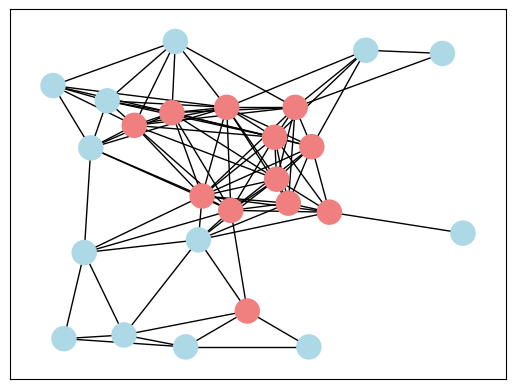

In [143]:
graph = test_dataset[32]
label = graph.y.item()
print(f'{label = }')
sample_func = partial(sampling, n_total=1.0, n_samples=1, n_points=21, on_edges=False, mode='connect')
metrics, subgraphs = sample_func(graph=graph)
gt = subgraphs[10][0]
reduced_gt = reduce_graph(gt)
perturbs = Batch.from_data_list(random_deletion(graph, gt, 0.7, 100))
reduced_perturbs = reduce_graph(perturbs)
try:
    reduced_perturbs.to(device)
    preds = gnn(reduced_perturbs)
except Exception as e:
    import traceback
    traceback.print_exc()
probs = preds.softmax(-1)
scores = probs[:, label]
score = scores.mean(0).item()
check = reduced_gt
print(check)
draw(check)

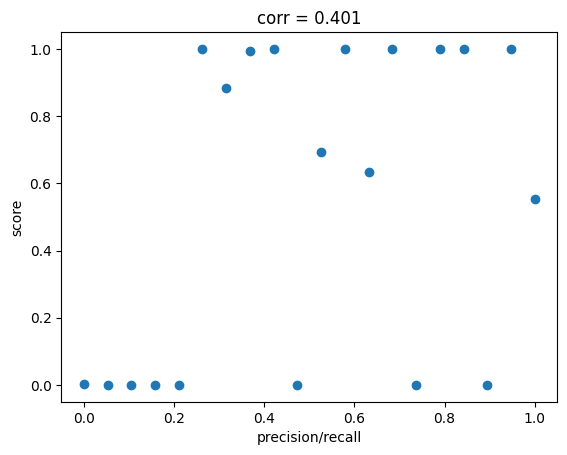

In [ ]:
scores = [score_confidence(Batch.from_data_list(subgraph), Batch.from_data_list([graph] * len(subgraph)), gnn).mean(0).item() for subgraph in subgraphs]
plot_corr(metrics, scores, 'precision/recall')

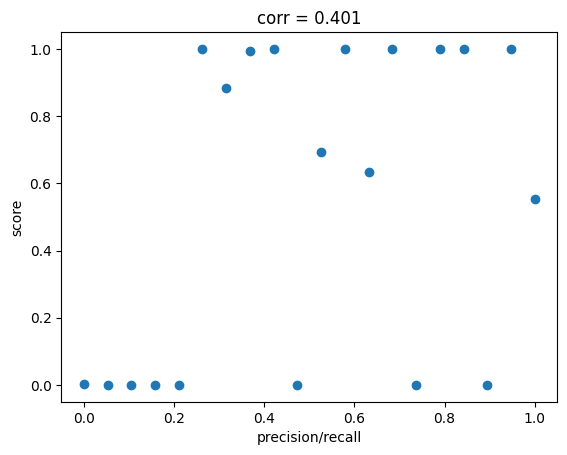

In [ ]:
scores = [score_random_deletion(Batch.from_data_list(subgraph), Batch.from_data_list([graph] * len(subgraph)), gnn, 800, 500).mean(0).item() for subgraph in subgraphs]
plot_corr(metrics, scores, 'precision/recall')

#### Full Test

In [ ]:
sample_func = partial(sampling, n_total=1.0, n_samples=100, n_points=20, on_edges=False)
metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [score_confidence])

In [ ]:
sample_func = partial(sampling, n_total=1.0, n_samples=100, n_points=20, on_edges=False)
metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [partial(score_random_deletion, n_del=0.3, n_samples=1)])

100%|██████████| 100/100 [28:16<00:00, 16.97s/it]


In [ ]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')
plt.savefig('./figure/mnist_random_1.0.png')

In [ ]:
on_edges = False
n_original = 50
n_level = 20
n_sub = 10
n_perturb = 50
for r_perturb in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.figure(figsize=(10, 5))
    for r_sub in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
        sample_func = partial(sampling, n_total=r_sub, n_samples=n_sub, n_points=n_level, on_edges=on_edges)
        metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:n_original]], gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=n_perturb, on_edges=on_edges)])
        scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
        scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
        plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall', label=f'{r_sub}', with_line=True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'./figure/mnist_random_nodes_del_{r_perturb}.png')
    plt.close()

In [ ]:
plt.figure(figsize=(10, 5))
for n_total in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    sample_func = partial(sampling, sample_func=sample_subgraphs, n_total=n_total, n_samples=100, n_points=20, on_edges=False)
    metrics, (scores_conf, ) = evaluate(test_dataset[torch.randperm(len(test_dataset))[:100]], gnn, sample_func, [score_confidence])
    scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
    scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
    plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall', label=f'{n_total}', with_line=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f'./figure/mnist_random_nodes.png')
plt.close()

### BA3Motif

In [5]:
import networkx as nx
from torch_geometric.utils import to_networkx
from datasets import BA3Motif
from gnns.ba3 import Net

data_path = 'data/BA3'
gnn_path = "models/gnns/ba3.pt"

gnn = torch.load(gnn_path, map_location=device).eval()

train_dataset = BA3Motif(data_path, train=True).shuffle()
test_dataset = BA3Motif(data_path, train=False)

label2name = {0: 'house', 1: 'grid', 2: 'circle'}
ground_truth_size = {0: 6, 1: 12, 2: 5}
ground_truth_size_nodes = {0: 5, 1: 9, 2: 5}
gt_sizes = [ground_truth_size[data.y.item()] for data in test_dataset]

def draw(g: Union[Data, int]):
    if isinstance(g, int):
        g = test_dataset[g]
    nx_g = to_networkx(g).to_undirected()
    if g.pos is not None:
        pos = dict(enumerate(g.pos.numpy()))
    else:
        pos = nx.spring_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True)

def sampling(graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 20, on_edges: bool = True, mode: str = 'random') -> Tuple[List[float], List[List[Data]]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    gt_size = ground_truth_size[graph.y.item()] if on_edges else ground_truth_size_nodes[graph.y.item()]
    n_total = round(n_total * gt_size)
    for n_pos in range(min(gt_size, n_total) + 1):
        subgraph = sample_subgraphs(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges, mode=mode)
        if subgraph is None:
            continue
        if n_total > gt_size:
            metrics.append(n_pos / gt_size)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

#### Case study

Class: 2
tensor([2])


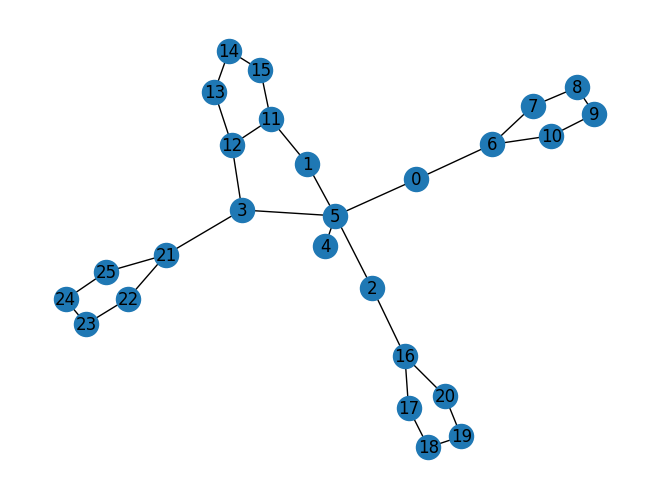

In [6]:
g = test_dataset[5]
print('Class:', g.y.item())
draw(g)

In [ ]:
sample_func = partial(sampling, n_total=1.0, n_samples=20, on_edges=True, mode='connect')
metrics, (scores_conf, ) = evaluate(test_dataset, gnn, sample_func, [score_confidence])

In [ ]:
sample_func = partial(sampling, n_total=1.0, n_samples=20, on_edges=True, mode='connect')
metrics, (scores_conf, ) = evaluate(test_dataset, gnn, sample_func, [partial(score_random_deletion, n_del=5, n_samples=20)])

In [ ]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')

#### Full test

In [ ]:
for label, gt_size in ground_truth_size.items():
    for r_perturb in [2, 4, 6, 8, 10, 1.0]:
        indices = [i for i, data in enumerate(test_dataset) if data.y.item() == label]
        for n_total in [1., 1.5, 2.0]:
            sample_func = partial(sampling, n_total=n_total, n_samples=20, mode='connect')
            metrics, (scores_conf, ) = evaluate(test_dataset[indices], gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=20)])
            scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
            scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
            plot_corr(scores_avg.metric, scores_avg.score, 'recall', label=f'{n_total}', with_line=True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./results/figures/ba3_{label2name[label]}_connect_del_{r_perturb}.png')
        plt.close()

#### Graphon

In [ ]:
from torch_geometric.utils import dense_to_sparse, to_dense_adj, to_undirected
import copy


def align_graphs(graphs: List[np.ndarray],
                 padding: bool = False, N: int = 0) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees
    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        max_num = max(max_num, N)

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

    return aligned_graphs, normalized_node_degrees, max_num, min_num

def universal_svd(aligned_graphs: List[np.ndarray], threshold: float = 2.02) -> np.ndarray:
    """
    Estimate a graphon by universal singular value thresholding.
    Reference:
    Chatterjee, Sourav.
    "Matrix estimation by universal singular value thresholding."
    The Annals of Statistics 43.1 (2015): 177-214.
    :param aligned_graphs: a list of (N, N) adjacency matrices
    :param threshold: the threshold for singular values
    :return: graphon: the estimated (r, r) graphon model
    """
    aligned_graphs = torch.from_numpy(np.array(aligned_graphs)).float().to( "cuda" )
    num_graphs = aligned_graphs.size(0)

    if num_graphs > 1:
        sum_graph = torch.mean(aligned_graphs, dim=0)
    else:
        sum_graph = aligned_graphs[0, :, :]  # (N, N)

    num_nodes = sum_graph.size(0)

    u, s, v = torch.svd(sum_graph)
    singular_threshold = threshold * (num_nodes ** 0.5)
    binary_s = torch.lt(s, singular_threshold)
    s[binary_s] = 0
    graphon = u @ torch.diag(s) @ torch.t(v)
    graphon[graphon > 1] = 1
    graphon[graphon < 0] = 0
    diagonal_mask = torch.eye(*graphon.shape, device=graphon.device).bool()
    graphon.masked_fill_(diagonal_mask, 0)
    graphon = graphon.cpu().numpy()
    torch.cuda.empty_cache()
    return graphon

def get_adjmatrices_groupby_class(dataset: BA3Motif) -> dict[int, List[np.ndarray]]:
    data_list = list(dataset)
    labels = sorted({data.y.item() for data in data_list})

    cls_adjs = {cls: [] for cls in labels}
    for data in data_list:
        adj = to_dense_adj(to_undirected(data.edge_index))[0].numpy()
        cls_adjs[data.y.item()].append(adj)
    return cls_adjs

In [ ]:
cls_adjs = get_adjmatrices_groupby_class(dataset=train_dataset)

In [ ]:
import random
idx = np.random.choice(len(aligned_adjs))

In [ ]:
plt.imshow(cls_adjs[cls][idx], cmap='gray')
# plt.imshow(aligned_adjs[idx], cmap='gray')

In [ ]:
cls = 1
all_adjs = sum(cls_adjs.values(), [])
aligned_adjs, _, _, _ = align_graphs(all_adjs, padding=True)
graphon = universal_svd(aligned_adjs, threshold=0.1)
plt.imshow(graphon, cmap='gray')

In [ ]:
def sample_from_graphon(graphon: np.ndarray):
    sample_adj = (np.random.rand(*graphon.shape) < graphon).astype(np.int32)
    # sample_adj = (graphon > 0.25).astype(np.int32)
    sample_adj = np.triu(sample_adj)
    sample_adj = sample_adj + sample_adj.T - np.diag(np.diag(sample_adj))
    sample_adj = sample_adj[sample_adj.sum(axis=1) != 0]
    sample_adj = sample_adj[:, sample_adj.sum(axis=0) != 0]
    A = torch.from_numpy(sample_adj)
    edge_index, _ = dense_to_sparse(A)
    num_nodes = int(torch.max(edge_index)) + 1
    graph = Data(edge_index=edge_index)
    return graph

graph = sample_from_graphon(graphon)
draw(graph)

#### OOD Block

In [ ]:
from ood_block import OODBlock, VariationalGCNEncoder

ood_evaluator: OODBlock = torch.load('models/ood_block/ba3.pth', map_location=device)

for label, gt_size in ground_truth_size.items():
    indices = [i for i, data in enumerate(test_dataset) if data.y.item() == label]
    for n_pos in range(gt_size + 1):
        rows = []
        for n_del in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
            for batch in tqdm(DataLoader(test_dataset[indices], batch_size=1, shuffle=False)):
                graph = batch[0]
                subgraphs = sample_subgraphs(graph, n_total=gt_size, n_pos=n_pos, n_samples=20, mode='connect')
                if subgraphs is None:
                    continue
                perturbs = Batch.from_data_list(sum([random_deletion(graph, gs, n_del=n_del, n_samples=20) for gs in subgraphs], []))
                reduced_perturbs = reduce_graph(perturbs)
                loss, auc, ap = ood_evaluator.evaluate([reduced_perturbs], device=device)
                rows.append([n_del, loss, auc, ap])
        ood_df = pd.DataFrame(rows, columns=['n_del', 'loss', 'auc', 'ap'])
        ood_df = ood_df.groupby('n_del', as_index=False).mean()
        plt.xlabel('n_del')
        for metric in ['loss', 'auc', 'ap']:
            plt.scatter(ood_df['n_del'], ood_df[metric], label=metric)
            plt.plot(ood_df['n_del'], ood_df[metric], alpha=0.1, c='k')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./figure/ba3_gt-{gt_size}_connect_n_pos-{n_pos}_ood.png')
        plt.close()

#### Explainers

In [6]:
from explainers import GNNExplainer, PGExplainer, SAExplainer, GradCAM, CXPlain, ReFine

split = round(len(train_dataset) * 0.1)

explainers = {
    'SA': SAExplainer().to(device),
    'GradCAM': GradCAM().to(device),
    'GNNExplainer': GNNExplainer().to(device),
    'PGExplainer': PGExplainer().to(device).train(gnn, train_dataset, verbose=True),
    'CXPlain': CXPlain().to(device).train(gnn, train_dataset[split:], train_dataset[:split], verbose=True),
    'ReFine': ReFine(train_dataset.num_classes).to(device).pretrain(gnn, train_dataset, verbose=True),
}

Epoch 30/30 | Graph 2700/2700: loss = 1.43684
Epoch: 050, Batch: 019, Loss: -3.4572, Val Loss: -3.3406, Val Loss: -3.3500, Val Loss: -3.3732, Val Loss: -3.3823, Val Loss: -3.3842, Val Loss: -3.3875, Val Loss: -3.3875, Val Loss: -3.3888, Val Loss: -3.3890, Val Loss: -3.3903, Val Loss: -3.3913, Val Loss: -3.3914, Val Loss: -3.3910, Val Loss: -3.3915, Val Loss: -3.3918, Val Loss: -3.3919, Val Loss: -3.3890, Val Loss: -3.3923, Val Loss: -3.3922, Val Loss: -3.3923, Val Loss: -3.3921, Val Loss: -3.3923, Val Loss: -3.3923, Val Loss: -3.3925, Val Loss: -3.3918, Val Loss: -3.3916, Val Loss: -3.3921, Val Loss: -3.3926, Val Loss: -3.3924, Val Loss: -3.3925, Val Loss: -3.3927, Val Loss: -3.3926, Val Loss: -3.3924, Val Loss: -3.3920, Val Loss: -3.3926, Val Loss: -3.3928, Val Loss: -3.3929, Val Loss: -3.3933, Val Loss: -3.3930, Val Loss: -3.3934, Val Loss: -3.3927, Val Loss: -3.3934, Val Loss: -3.3916, Val Loss: -3.3919, Val Loss: -3.3926, Val Loss: -3.3932, Val Loss: -3.3930, Val Loss: -3.3934, Val

In [12]:
select_ratio = 1.0
perturb_ratio = 0.1

scores = {}
for name, explainer in explainers.items():
    original_graphs = []
    masks = []
    for graph in tqdm(test_dataset):
        edge_mask = explainer.explain_graph(gnn, graph)
        mask_adj = to_dense_adj(graph.edge_index, None, edge_mask, graph.num_nodes)[0]
        mask_adj = torch.triu((mask_adj + mask_adj.T) / 2)
        edge_mask = mask_adj[graph.edge_index[0], graph.edge_index[1]]

        original_graphs.append(graph)
        masks.append(edge_mask)

    explanatory_graphs = []
    recalls = []
    for graph, edge_mask in zip(original_graphs, masks):
        K_GT = ground_truth_size[graph.y.item()]
        # select top K edges
        K = round(K_GT * select_ratio)
        select_indices = edge_mask.argsort(descending=True)[:K]
        hard_edge_mask = torch.zeros_like(edge_mask, dtype=torch.bool)
        hard_edge_mask[select_indices] = True
        explanatory_graph = graph.clone()
        explanatory_graph.edge_index, explanatory_graph.edge_attr = to_undirected(
            graph.edge_index[:, hard_edge_mask], graph.edge_attr[hard_edge_mask], num_nodes=graph.num_nodes)

        explanatory_graphs.append(explanatory_graph)

        recall = (hard_edge_mask & graph.ground_truth_mask).sum().item() / K_GT
        recalls.append(recall)

    original_graphs = Batch.from_data_list(original_graphs)
    explanatory_graphs = Batch.from_data_list(explanatory_graphs)

    recalls = np.array(recalls)
    pap_scores = score_confidence(explanatory_graphs.to(device), original_graphs.to(device), gnn.to(device)).cpu().numpy()
    our_scores = score_random_deletion(explanatory_graphs.to(device), original_graphs.to(device), gnn.to(device), n_del=perturb_ratio, n_samples=20).cpu().numpy()

    scores[name] = {
        'recall': recalls,
        'RM': pap_scores,
        'SAR': our_scores
    }

100%|██████████| 300/300 [03:37<00:00,  1.38it/s]


In [13]:
def correlation(recalls: np.ndarray, scores: np.ndarray, method='kendalltau') -> float:
    import scipy.stats as stats
    corr = getattr(stats, method)(recalls, scores)[0]
    return (corr + 1) / 2

result = pd.DataFrame(
    {explainer_name: {method: correlation(score['recall'], score[method]) for method in score.keys()} 
     for explainer_name, score in scores.items()},
)
result

,SA,GradCAM,GNNExplainer,PGExplainer,CXPlain,ReFine
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
RM,0.601302,0.629830,0.456721,0.446330,0.480287,0.569118
SAR,0.720966,0.693858,0.449733,0.433175,0.474613,0.553995


In [14]:
overall_result = pd.DataFrame(
    {explainer_name: {method: score[method].mean() for method in score.keys()}
     for explainer_name, score in scores.items()},
)
overall_result['tau'] = [correlation(overall_result.loc['recall'], overall_result.loc[method]) for method in overall_result.index]
overall_result

,SA,GradCAM,GNNExplainer,PGExplainer,CXPlain,ReFine,tau
recall,0.340389,0.386111,0.622611,0.152889,0.581000,0.646056,1.000000
RM,0.428968,0.581337,0.281266,0.344293,0.294706,0.267400,0.200000
SAR,0.495358,0.536489,0.503910,0.515309,0.493878,0.528939,0.533333


house
0.6226111111111111 0.28126633 0.5039095
0.4567209586252755 0.4497326306417144


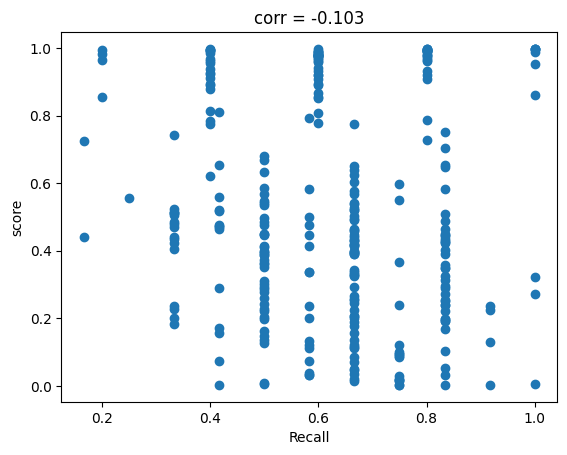

In [21]:
label = 0
print(label2name[label])
mask = (test_dataset.data.y == label).cpu().numpy()
precisions, pap_scores, our_scores = scores['GNNExplainer'].values()
print(precisions.mean(), pap_scores.mean(), our_scores.mean())
print(correlation(precisions, pap_scores), correlation(precisions, our_scores))
plot_corr(precisions, our_scores, 'Recall')

<AxesSubplot: >

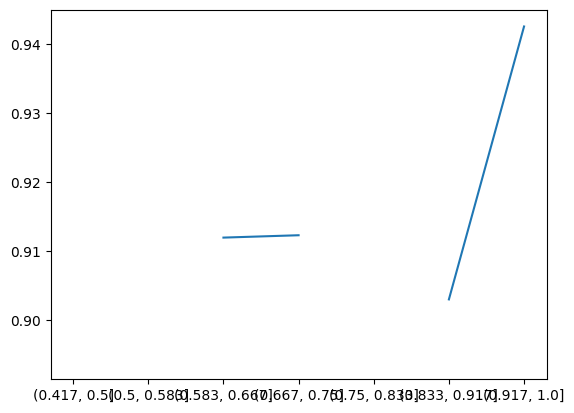

In [65]:
pd.Series(our_scores).groupby(pd.cut(precisions, np.linspace(0, 1, ground_truth_size[label]+1))).mean().plot()

### TR3Motif

In [44]:
import networkx as nx
from torch_geometric.utils import to_networkx
from datasets import TR3Motif
from gnns.tr3 import Net

data_path = 'data/TR3'
gnn_path = "models/gnns/tr3.pt"

gnn = torch.load(gnn_path, map_location=device).eval()

train_dataset = TR3Motif(data_path, train=True)
test_dataset = TR3Motif(data_path, train=False)

# 0: circle, 1: house, 2: crane
label2name = {0: 'circle', 1: 'house', 2: 'crane'}
ground_truth_size = {0: 5, 1: 6, 2: 6}
ground_truth_size_nodes = {0: 5, 1: 5, 2: 5}
gt_sizes = [ground_truth_size[data.y.item()] for data in test_dataset]

def draw(g: Union[Data, int]):
    if isinstance(g, int):
        g = test_dataset[g]
    nx_g = to_networkx(g).to_undirected()
    if g.pos is not None:
        pos = dict(enumerate(g.pos.numpy()))
    else:
        pos = nx.spring_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True)

def sampling(graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 20, on_edges: bool = True, mode: str = 'random') -> Tuple[List[float], List[List[Data]]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    gt_size = ground_truth_size[graph.y.item()] if on_edges else ground_truth_size_nodes[graph.y.item()]
    n_total = round(n_total * gt_size)
    for n_pos in range(min(gt_size, n_total) + 1):
        subgraph = sample_subgraphs(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges, mode=mode)
        if subgraph is None:
            continue
        if n_total > gt_size:
            metrics.append(n_pos / gt_size)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Class: 0 #nodes: 18 #edges: 19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 2])
tensor([[ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  5,  6,
          7,  8,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 16,
         17, 17],
        [ 1,  2,  3,  0,  4,  5,  6,  0,  7,  8,  9,  0, 10, 11, 12,  1,  1,  1,
          2,  2,  2,  3, 13,  3, 12,  3, 11, 10, 14, 17, 13, 15, 14, 16, 15, 17,
         13, 16]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True])


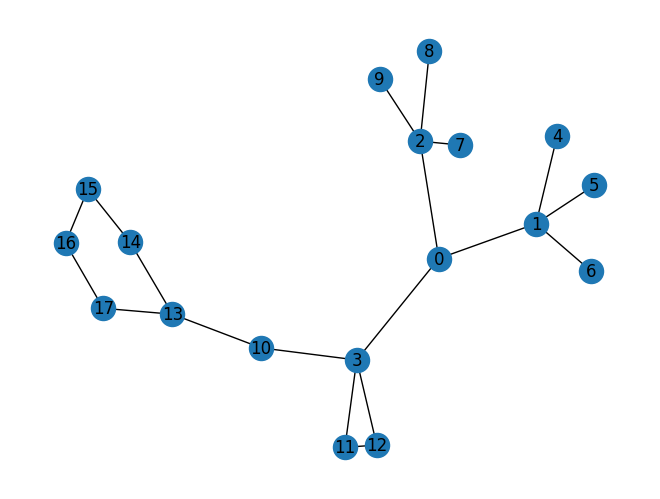

In [54]:
g = test_dataset[23]
print('Class:', g.y.item(), '#nodes:', g.num_nodes, '#edges:', g.num_edges // 2)
print(g.z)
print(g.edge_index)
print(g.ground_truth_mask)
draw(g)

#### Full test

In [46]:
for label, gt_size in ground_truth_size.items():
    for r_perturb in [2, 4, 6, 8, 10, 1.0]:
        indices = [i for i, data in enumerate(test_dataset) if data.y.item() == label]
        for n_total in [1., 1.5, 2.0]:
            sample_func = partial(sampling, n_total=n_total, n_samples=20, mode='connect')
            metrics, (scores_conf, ) = evaluate(test_dataset[indices], gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=20)])
            scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
            scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
            plot_corr(scores_avg.metric, scores_avg.score, 'recall', label=f'{n_total}', with_line=True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'results/figures/tr3_{label2name[label]}_connect_del_{r_perturb}.png')
        plt.close()

100%|██████████| 148/148 [03:41<00:00,  1.49s/it]


### Mutagenicity

In [103]:
import networkx as nx
from torch_geometric.utils import to_networkx

from datasets import Mutagenicity
from gnns.mutagenicity import Net

data_path = 'data/Mutagenicity'
gnn_path = "models/gnns/mutagenicity.pt"

train_dataset = Mutagenicity(data_path, mode='train')
test_dataset = Mutagenicity(data_path, mode='test')
explain_dataset = Mutagenicity(data_path, mode='explain')

gnn = torch.load(gnn_path, map_location=device).eval()

colors = ['orange','red','lime','green','blue','orchid','darksalmon','darkslategray','gold','bisque','tan','lightseagreen','indigo','navy']
def draw(g: Data):
    nx_g = to_networkx(g)
    if g.pos is not None:
        pos = dict(enumerate(g.pos.numpy()))
    else:
        pos = nx.kamada_kawai_layout(nx_g)
    node_colors = [colors[l] for l in g.z.tolist()]
    node_labels = {i: Mutagenicity.node_label_map[l] for i, l in enumerate(g.z.tolist())}
    edge_list = g.edge_index.t().tolist()
    edge_colors = ['red' if mask else 'black' for mask in g.ground_truth_mask.tolist()]
    nx.draw_networkx(nx_g, pos=pos, with_labels=True, node_color=node_colors, labels=node_labels, edgelist=edge_list, edge_color=edge_colors, arrows=False)

def sampling(graph: Data, n_total: Union[int, float] = 1.0, n_samples: int = 20, on_edges: bool = True, mode: str = 'random') -> Tuple[List[float], List[Batch]]:
    """Sample `n_samples` subgraphs from `graph` and return the metrics and the subgraphs."""
    metrics = []
    subgraphs = []
    gt_size = 2 if on_edges else 3
    n_total = round(n_total * gt_size)
    for n_pos in range(min(gt_size, n_total) + 1):
        subgraph = sample_subgraphs(graph, n_total=n_total, n_pos=n_pos, n_samples=n_samples, on_edges=on_edges, mode=mode)
        if subgraph is None:
            continue
        if n_total > gt_size:
            metrics.append(n_pos / gt_size)
        else:
            metrics.append(n_pos / n_total)
        subgraphs.append(subgraph)
    return metrics, subgraphs

# stats
from itertools import chain
stats = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
for g in chain(train_dataset, test_dataset):
    has_gt = g.ground_truth_mask.any().item()
    if g.y.item() == 0:
        stats['TP'] += has_gt
        stats['FN'] += not has_gt
    else:
        stats['TN'] += not has_gt
        stats['FP'] += has_gt
print(stats)

{'TP': 1015, 'FP': 341, 'TN': 1595, 'FN': 1386}


nonmutagenic


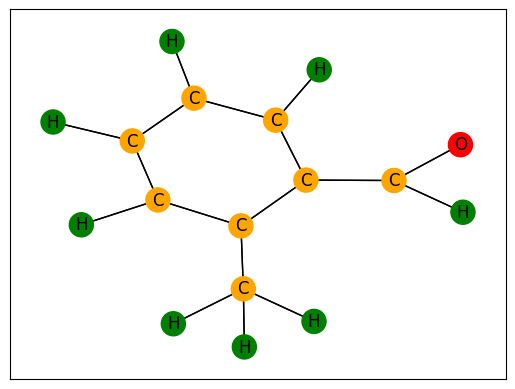

In [100]:
i = np.random.randint(0, len(train_dataset) - 1)
g = train_dataset[i]
print(('' if g.y.item() == 0 else 'non') + 'mutagenic')
draw(g)

In [61]:
sample_func = partial(sampling, n_total=1.0, n_samples=20, on_edges=True, mode='connect')
metrics, (scores_conf, ) = evaluate(explain_dataset, gnn, sample_func, [score_confidence])

100%|██████████| 1015/1015 [01:20<00:00, 12.64it/s]


In [64]:
sample_func = partial(sampling, n_total=1.0, n_samples=20, on_edges=True, mode='connect')
metrics, (scores_conf, ) = evaluate(explain_dataset, gnn, sample_func, [partial(score_random_deletion, n_del=5, n_samples=20)])

100%|██████████| 1015/1015 [13:18<00:00,  1.27it/s]


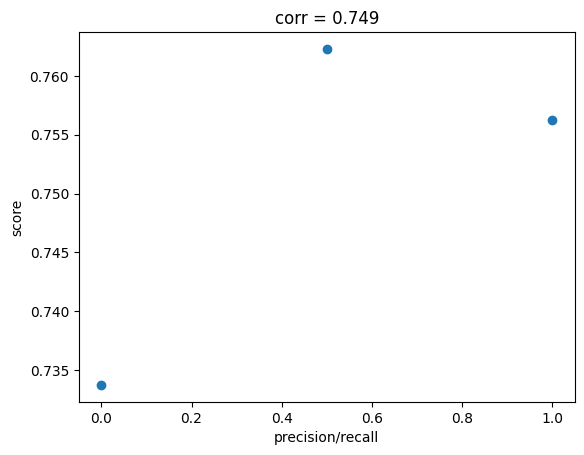

In [65]:
scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
plot_corr(scores_avg.metric, scores_avg.score, 'precision/recall')

#### Full test

In [69]:
for n_total in [1., 1.5, 2.0, 2.5, 3.0]:
    sample_func = partial(sampling, n_total=n_total, n_samples=20, mode='connect')
    metrics, (scores_conf, ) = evaluate(explain_dataset, gnn, sample_func, [score_confidence])
    scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
    scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
    plot_corr(scores_avg.metric, scores_avg.score, 'recall', label=f'{n_total}', with_line=True)
plt.legend()
plt.tight_layout()
plt.savefig('results/figures/mutag_connect.png')
plt.close()

100%|██████████| 1015/1015 [01:45<00:00,  9.61it/s]


In [72]:
for r_perturb in [1.0]:
    for n_total in [1., 1.5, 2.0, 2.5, 3.0]:
        sample_func = partial(sampling, n_total=n_total, n_samples=20, mode='connect')
        metrics, (scores_conf, ) = evaluate(explain_dataset, gnn, sample_func, [partial(score_random_deletion, n_del=r_perturb, n_samples=20)])
        scores_df = pd.DataFrame({'metric': metrics, 'score': scores_conf})
        scores_avg = scores_df.groupby('metric', as_index=False)['score'].mean()
        plot_corr(scores_avg.metric, scores_avg.score, 'recall', label=f'{n_total}', with_line=True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/figures/mutag_connect_del_{r_perturb}.png')
    plt.close()

100%|██████████| 1015/1015 [12:56<00:00,  1.31it/s]


## Comparison
Labels, Original pred, oracle rationale pred

In [ ]:
labels = []
original_preds = []
rationale_preds = []
filled_rationale_preds = []
for graphs in tqdm(DataLoader(test_dataset, batch_size=256, shuffle=False)):
    rationales = get_oracle_rationale(graphs)
    filled_rationales_list = fill_graph(graphs, rationales, fill_times=fill_times)

    labels.append(graphs.y.squeeze())
    with torch.no_grad():
        original_preds.append(gnn(graphs))
        rationale_preds.append(gnn(reduce_graph(rationales)))
        filled_rationale_preds.append(torch.stack([gnn(reduce_graph(filled_rationales)) for filled_rationales in filled_rationales_list]).mean(0))

labels = torch.cat(labels).cpu().numpy()
original_preds = torch.cat(original_preds).cpu().numpy()
rationale_preds = torch.cat(rationale_preds).cpu().numpy()
filled_rationale_preds = torch.cat(filled_rationale_preds).cpu().numpy()

### Confidence w.r.t a specified class

#### Logits

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls
    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Logits of class {cls})')
    ax.set_ylim(-30, 1)
    x = range(cls_mask.sum())
    ax.scatter(x, original_preds[cls_mask, cls], label='original', s=2)
    ax.scatter(x, rationale_preds[cls_mask, cls], label='rationale', s=2)
    ax.legend()

#### Probabilities

In [ ]:
original_probs = softmax(original_preds, axis=-1)
rationale_probs = softmax(rationale_preds, axis=-1)

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls
    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Probabilities of class {cls})')
    x = range(cls_mask.sum())
    ax.scatter(x, original_probs[cls_mask, cls], label='original', s=2)
    ax.scatter(x, rationale_probs[cls_mask, cls], label='rationale', s=2)
    ax.legend()

### Performace

#### Class-wise

In [ ]:
nrow = 3
ncol = math.ceil(10 / nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(6.4 * ncol, 4.8 * nrow))
for cls in range(10):
    cls_mask = labels == cls

    cls_original_probs = original_probs[cls_mask]
    cls_rationale_probs = rationale_probs[cls_mask]
    cls_original_acc = (cls_original_probs.argmax(-1) == cls).mean()
    cls_rationale_acc = (cls_rationale_probs.argmax(-1) == cls).mean()

    ax = axes[cls // ncol][cls % ncol]
    ax.set_title(f'Averaged prob. distribution of class {cls}')
    x = range(10)
    ax.bar(x, cls_original_probs.mean(axis=0), label=f'original (ACC = {cls_original_acc:.4f})')
    ax.bar(x, cls_rationale_probs.mean(axis=0), label=f'rationale (ACC = {cls_rationale_acc:.4f})')
    ax.legend()

#### Overall

In [ ]:
original_acc = (original_probs.argmax(-1) == labels).mean()
rationale_acc = (rationale_probs.argmax(-1) == labels).mean()
print(f'original ACC = {original_acc}')
print(f'rationale ACC = {rationale_acc}')

## Playground

In [ ]:
x = np.linspace(0, 1, 100)
y = 0.5 * x + np.random.normal(0, 0.005, size=x.shape)
plt.xlabel('Prec(·,Gs*)')
plt.ylabel('s(·)')
plt.yticks([])
plt.scatter(x, y, s=2, label='0.75')
plt.scatter(x, y, s=2, label='1.0')
plt.scatter(x, y, s=2, label='1.5')
plt.scatter(x, y, s=2, label='2.0')
plt.legend()